# Simulation and estimation in a Markov model of breast cancer

In this project, we will work with the following Markov model:

The model follows women after they had their breast tumor removed. The
cancer may reappear close to the removed tumor. This is called local recurrence, and the woman enters state 2. The cancer may also reappear distant
from where it was operated. This is called distant metastatis. Both things
may also occour. Death can occur from any state. In this model, once the
death state has been entered, it can never be left again. This means the
simulation should be terminated once this state has been reached

## Task 1

Assume that one time step equals one month. Simulate 1000 women, all
starting in state 1, until death. Summarize the lifetime distribution of the
women, after surgery, for example using a histogram. In what proportion of
women does the cancer eventually reappear, locally?

In [165]:
import numpy as np

# Our markov chain simulation, with given n: number of women and P: probability matrix (transition matrix)
def absorbing_markov(n, P):
    lifetime = []
    for _ in range(n):
        state = []
        # Initial state
        current_state = 0 # state 1 --> index 0
        state.append(current_state) # first state which is always state 1
        k = 0
        while current_state != 4:  # Absorbing state (death state)
            # Making a jump based on p=P[current state], returning the state index (state nr. -1)
            next_state = np.random.choice([0, 1, 2, 3, 4], p=P[current_state])
            state.append(next_state) # Keeping records of which state the women is in
            current_state = next_state # Change of state to next state
            k += 1
            if current_state == 4:
                lifetime.append(state) # keeping records of each lifetime

    return lifetime

# Probability matrix P with probabilities:
P = np.array([
    [0.9915, 0.005, 0.0025, 0.0, 0.001],  # state 1 to all the other
    [0.0, 0.986, 0.005, 0.004, 0.005],   # state 2: local recurrence
    [0.0, 0.0, 0.992, 0.003, 0.005],   # state 3:  distant metastatis
    [0.0, 0.0, 0.0, 0.991, 0.009],   # state 4: both local recurrence and distant metastatis
    [0.0, 0.0, 0.0, 0.0, 1.0]    # state 5: death state, no return hence 1.0 probabilites in P_[4][4]
])

nr_women = 1_000
## Simulating ##
lifetime = absorbing_markov(nr_women, P)
    

Fraction of women where the cancer re-appears locally (state 2) is 0.585 or 585 women out of 1000.
Mean of months lived after surgery: 257.87 and in years: 21.49


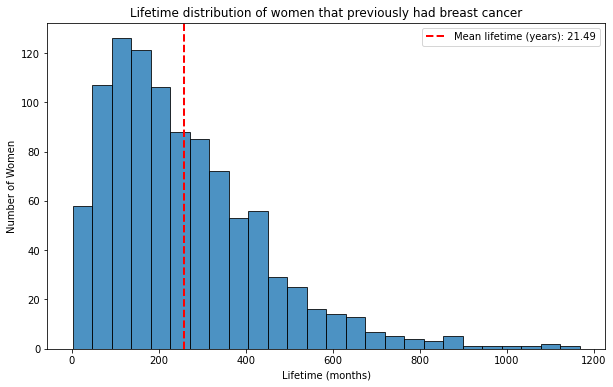

In [174]:
import matplotlib.pyplot as plt

# Manipulation and plotting a histogram
lifetimes_month = []
for i in range(len(lifetime)):
    lifetime_list = lifetime[i]
    lifetimes_month.append(len(lifetime_list))

lifetimes = np.array(lifetimes_month) # Calculating the lifetime of each women, in months

# Calculate the fraction of women where the cancer re-appears locally (state 2, index 1)
reappears = 0
for i in range(len(lifetime)):
    lifetime_list = lifetime[i]
    if 1 in lifetime_list:
        reappears += 1
frac_reappears = reappears/nr_women

print(
    f"Fraction of women where the cancer re-appears locally (state 2) is "
    f"{frac_reappears} or {reappears} women out of {nr_women}.")

mean_lifetime= np.mean(lifetimes)
print(f"Mean of months lived after surgery: {mean_lifetime:.2f} and in years: {mean_lifetime/12:.2f}")

# Plotting histogram
plt.figure(figsize=(10,6))
plt.hist(lifetimes,bins="auto", alpha=0.8, edgecolor="black")
plt.title('Lifetime distribution of women that previously had breast cancer')
plt.axvline(mean_lifetime, color='red', linestyle='dashed', linewidth=2, 
            label=f'Mean lifetime (years): {mean_lifetime/12:.2f}')
plt.xlabel('Lifetime (months)')
plt.ylabel('Number of Women')
plt.legend()
plt.show()

## Task 2
